# Investigation of the Bayesian and non-Bayesian Time Series Forcasting Fraemworks in Application to OSS Systems of the LTE/LTE-A and 5G Mobile Networks 

This Jupyter Notebook belongs to the following paper:

> Fadeev V.A., Zaidullin S.V., Nadeev A.F. (2022). [Investigation of the Bayesian and non-Bayesian time series forecasting frameworks in application to OSS systems of the LTE/LTE-A and 5G mobile networks](http://media-publisher.ru/wp-content/uploads/Nom-4-2022s.pdf). T-Comm, vol. 16, no.4, pр. 52-60.

**Autors of the code**:
- Vladimir Fadeev ([kirlf](https://github.com/kirlf))
- Shakhrozy Zaidullin ([shortferd](https://github.com/shortferd))



In [1]:
!pip install hmmlearn==0.2.5
!pip install pmdarima==1.8.5
!pip install pydlm==0.1.1.11
!pip install pomegranate==0.14.8
!pip install xgboost==1.6.1


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 369 kB 5.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 5.0 MB/s 
     |████████████████████████████████| 9.8 MB 38.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 2.0 MB/s 
  Created wheel for pydlm: filename=pydlm-0.1.1.11-py2.py3-none-any.whl size=58995 sha256=181fc96852b1fdcf69b71876e2785b977d8d3a103ea6c9cd7dae84dd60156d5c
  Stored in directory: /root/.cache/pip/wheels/1d/fb/0c/6611fce0b9f3611ac6498dbddb7a9b5e67c09684acf6db285d
Successfully built pydlm
Looking in in

In [2]:
import numpy as np
import pandas as pd

In [3]:
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import seaborn as sns
sns.set(style="whitegrid")

from pylab import rcParams

In [4]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima.arima import ARIMA
from sklearn.svm import SVR
from xgboost import XGBRegressor, plot_importance
from pydlm import dlm, dynamic, seasonality, autoReg, modelTuner

from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [5]:
from pomegranate import MultivariateGaussianDistribution as mvgauss
from pomegranate import HiddenMarkovModel as hmm_pom

In [6]:
# Features selections

In [7]:
def create_features(df, label=None):
    
    """
    Creates time series features from datetime index.
    
    Parameters
    ----------
    df: pandas.DataFrame
        Input data frame.
    label: str (default None)
        Name of the considered KPI.

    Returns
    -------
    pandas.DataFrame
        Output data frame.
    """
    
    new_df = df.copy()
    new_df.index = df["DT"]
    new_df['date'] = new_df.index
    new_df['hour'] = new_df['date'].dt.hour
    new_df['day_of_year'] = new_df['date'].dt.dayofyear

    X = new_df[['hour', 'day_of_year']]

    #new_df['day_of_week'] = new_df['date'].dt.dayofweek
    #new_df['quarter'] = new_df['date'].dt.quarter
    #new_df['month'] = new_df['date'].dt.month
    #new_df['day_of_month'] = new_df['date'].dt.day
    #new_df['week_of_year'] = new_df['date'].dt.isocalendar().week
    
    #X = new_df[['hour','day_of_week','quarter','month',
    #       'day_of_year','day_of_month','week_of_year']]
        
    if label:
        y = df[label]
        return X, y
    return X

In [8]:

class ModelTrainer:
    """
    Class for models training automatization.

    Attributes
    ----------
    model_type: str
    One of the available models name or abrivation:
      - 'HW' (Holt-Winters model)
      - 'SARIMA'
      - 'SARIMAX'
      - 'SARIMA (Kalman)'
      - 'SARIMAX (Kalman)'
      - 'DLM' (Dynamical Linear Models)
      - 'SVR'
      - 'XGboost'
    """
    def __init__(self, 
                model_type, 
                scale_target=False):
      
      self.model_type = model_type

    @staticmethod
    def __holt_winters_fp(y_train, X_test, **model_kwargs):
        """ Holt-Winter's method (triple exponential smoothing) """

        old_index = X_test.index
        X_test.reset_index(inplace=True)

        seasonal_periods = model_kwargs.get("seasonal_periods", 24)
        model = ExponentialSmoothing(y_train,
                                     trend="add",
                                     seasonal="add", 
                                     seasonal_periods=seasonal_periods).fit()

        predictions = model.predict(start=X_test.index[0], end=X_test.index[-1])
        X_test.set_index(old_index, inplace=True)
        return predictions

    @staticmethod
    def __sarimax_fp(y_train, X_test, X_train=None, **model_kwargs):
        """ SARIMAX model 
        (Seasonal Autoregressive Integrated Moving Averaging 
        with exogenous variables)
        """

        seasonal_periods = model_kwargs.get("seasonal_periods", 24)
        mle_regression = model_kwargs.get("mle_regression", True)
        sarimax_kwargs = {"mle_regression": mle_regression}

        # Based on the pre-estimation using AutoARIMA (takes several hours)
        order = (2, 0, 1) 
        seasonal_order = (1, 0, 2, seasonal_periods)

        model = ARIMA(order, 
                      seasonal_order=seasonal_order,
                      **sarimax_kwargs).fit(y_train, 
                                            X=X_train)

        if X_train is not None:
            predictions = model.predict(X=X_test, n_periods=X_test.shape[0])
        else:
             predictions = model.predict(n_periods=X_test.shape[0])

        return predictions

    @staticmethod
    def __pydlm_fp(y_train, X_test, X_train, **model_kwargs):
        """ Dynamical linear models
        """

        seasonal_periods = model_kwargs.get("seasonal_periods", 24)

        dynamic_comp = dynamic(features=[list(i) for i in X_train.to_numpy()], 
                                             name="time_series_feature")

        seasonality_comp = seasonality(period=seasonal_periods)

        model = dlm(y_train) + dynamic_comp + seasonality_comp + autoReg()
        model.fit()

        feature_dict = {"time_series_feature": [list(i) for i in X_test.to_numpy()]}
        predictions, vars = model.predictN(N=X_test.shape[0], 
                                           featureDict=feature_dict)

        return predictions

    @staticmethod
    def __svr_fp(y_train, X_test, X_train, **model_kwargs):

        """ Support vector regression """

        # This option is used extarnal scaler

        y_scaler = StandardScaler()
        X_scaler = StandardScaler()

        X_train = X_scaler.fit_transform(X_train)
        X_test = X_scaler.fit_transform(X_test)
        y_train = y_scaler.fit_transform(y_train.values.reshape(-1,1))

        model = SVR(kernel="rbf", 
                    C=100, 
                    gamma=0.1, 
                    epsilon=0.1).fit(X_train, y_train)

        predictions_scaled = model.predict(X_test)
        predictions = y_scaler.inverse_transform(predictions_scaled.reshape(-1,1))

        return predictions

    def fit_predict(self, 
                  y_train,
                  X_test, 
                  X_train=None,
                  **model_kwargs):

        """ 
        Fits the model and predicts the values 

        Parameters
        ----------

        y_train: 1-D array
          Training target vector.

        X_test: 2-D array
          Testing features matrix.

        X_test: 2-D array
          Training features matrix.

        Returns
        -------

        predictions: 1-D array
          Predicted values.

        """


        if self.model_type == "HW":
            predictions = self.__holt_winters_fp(y_train, 
                                               X_test, 
                                               **model_kwargs)

        elif self.model_type == "SARIMAX":
            predictions = self.__sarimax_fp(y_train, 
                                          X_test, 
                                          X_train, 
                                          **model_kwargs)
        elif self.model_type == "SARIMA":
            predictions = self.__sarimax_fp(y_train, 
                                          X_test, 
                                          **model_kwargs)

        elif self.model_type == "SARIMAX (Kalman)":
            model_kwargs.update({"mle_regression": False})
            predictions = self.__sarimax_fp(y_train, 
                                          X_test, 
                                          **model_kwargs)

        elif self.model_type == "SARIMA (Kalman)":
            model_kwargs.update({"mle_regression": False})
            predictions = self.__sarimax_fp(y_train, 
                                          X_test,
                                          X_train,
                                          **model_kwargs)

        elif self.model_type == "DLM":
            predictions = self.__pydlm_fp(y_train, 
                                        X_test, 
                                        X_train, 
                                        **model_kwargs)

        elif self.model_type == "SVR":
            predictions = self.__svr_fp(y_train, 
                                      X_test, 
                                      X_train)

        elif self.model_type == "XGBoost":
            model = XGBRegressor(n_estimators=1000).fit(X_train, y_train)
            predictions = model.predict(X_test)

        return predictions


In [9]:
## Specify the name of KPI
KPI = "E_RAB_SETUP_FR"

## Specify year
year_v = 2019

In [10]:
## Extraction ot the data
path = "./data/"
df = pd.read_excel(f"{path}{KPI}_LTE.xlsx", sheet_name=str(year_v))
df = df[["DT", KPI]]
df = df.loc[(df["DT"] >= "01.01.%d" % year_v) & (df["DT"] < "01.01.%d" % (year_v+1))]
df = (df.set_index('DT').reindex(pd.date_range(start=f'1/1/{year_v}', end=f'31/12/{year_v}', freq='H'))).fillna(method='ffill')
df["DT"] = df.index
df.describe()

,E_RAB_SETUP_FR
count,8737.000000
mean,0.205401
std,0.238278
min,0.021416
25%,0.113951
50%,0.181857
75%,0.234216
max,7.417320


Text(0.5, 1.0, 'E_RAB_SETUP_FR (single-sided)')

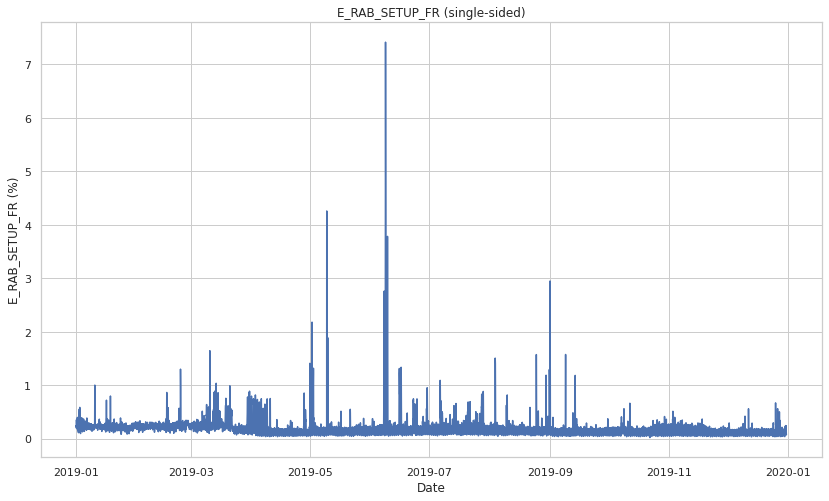

In [11]:
## Visualization of the time series single-sided
plt.figure(figsize=(14, 8))
plt.plot(df["DT"], df[KPI])
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("%s (%s)" % (KPI, "%"))
plt.title("%s (single-sided)" % KPI)

Text(0.5, 1.0, 'E_RAB_SETUP_FR (several days)')

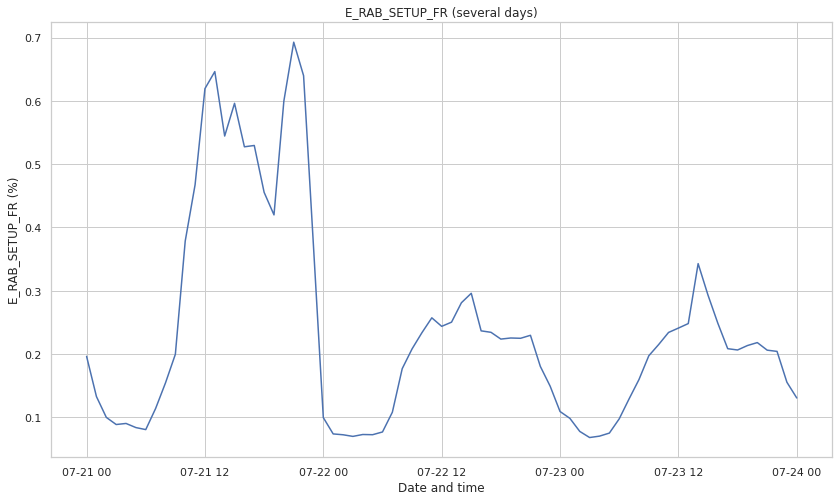

In [12]:
daily = df.copy()
daily["DT"] = pd.to_datetime(daily["DT"])
daily = daily.loc[(df["DT"] >= "21.07.%d" % year_v) & (df["DT"] <= "24.07.%d" % year_v)]

plt.figure(figsize=(14, 8))
plt.plot(daily["DT"], daily[KPI])
plt.grid(True)
plt.xlabel("Date and time")
plt.ylabel("%s (%s)" % (KPI, "%"))
plt.title("%s (several days)" % KPI)

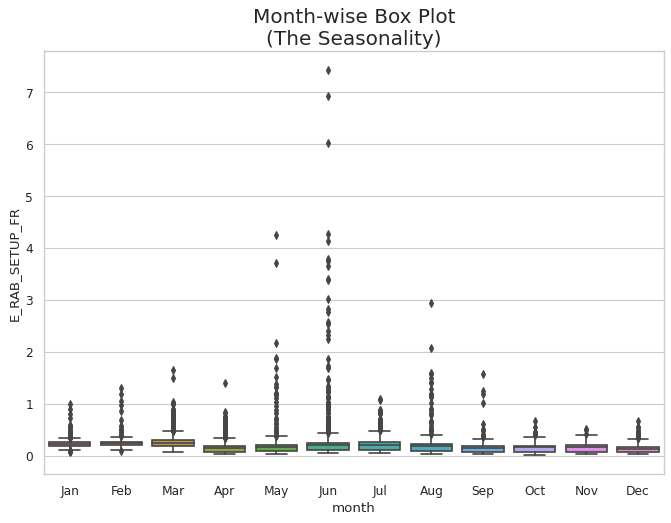

In [13]:
df['year'] = [d.year for d in df.DT]
df['month'] = [d.strftime('%b') for d in df.DT]
years = df['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 1, figsize=(10,7), dpi= 80)
sns.boxplot(x='month', y=KPI, data=df)

# Set Title
axes.set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

# Regular part forecasting

Models to research:
- Continuous State-space (PyDLM)
- Holts-Winter's method (MLE and Kalman based training)
- SARIMAX (MLE and Kalman based training)
- Polynomial regression
- Support Vector Regression
- XGBoost


In [14]:
from sklearn.metrics import (mean_absolute_error, 
                             median_absolute_error, 
                             mean_squared_error)
from sklearn.model_selection import TimeSeriesSplit


def timeseries_cv_score(series, 
                        KPI,
                        model_name,
                        n_splits,
                        sc_X = None,
                        sc_y = None,
                        on_index=True,
                        **model_kwargs):

    """ Time series cross validation. 
        This function prints out the following scores:
          - Median Absolute Error
          - Mean Absolute Error (MAE)
          - Mean Squared Error (MSE)
          - Root Mean Squared Error (RMSE)
    
    Parameters
    __________
    
    series: pandas.DataFrame
      Input data frame.
    
    KPI: str
      Name of the column to use (considered Key Performance Identifier).
    
    model_name: object
      inititalizes the instance of the explored model class
    
    n_splits: int
      How many splits should be done for the cross-validation procedure.
    
    """

    print(f"\n{model_name}")
    
    # errors array
    median_aes = []
    maes = []
    mses = []
    rmses = []    
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=n_splits) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train_indexes, test_indexes in tscv.split(series):
        
        X_train, y_train = create_features(series.iloc[train_indexes], 
                                           label=KPI) # training sets
        X_test, y_test = create_features(series.iloc[test_indexes], 
                                         label=KPI) # testing sets
        
        
        # Fit the model and predict the values 
        predictions = ModelTrainer(model_name).fit_predict(y_train, 
                                                           X_test, 
                                                           X_train,
                                                           **model_kwargs)

        # Errors counting
        
        median_aes.append(median_absolute_error(predictions, y_test))
        maes.append(mean_absolute_error(predictions, y_test))
        mses.append(mean_squared_error(predictions, y_test))
        rmses.append(mean_squared_error(predictions, y_test, squared=False))
    
    print("Median AE: ", np.mean(np.array(median_aes)))
    print("MAE: ", np.mean(np.array(maes)))
    print("MSE: ", np.mean(np.array(mses)))
    print("RMSE: ", np.mean(np.array(rmses)))

In [15]:
import warnings
warnings.filterwarnings('ignore')

# ARIMA takes couple of hours

#cases = ["SARIMAX", "SARIMAX (Kalman)", "SARIMA", "SARIMA (Kalman)", 
#         "SVR", "HW", "XGBoost", "DLM"]

cases = ["SVR", "HW", "XGBoost", "DLM"]

for model_name in cases:
    timeseries_cv_score(df, KPI, model_name, n_splits=12)


SVR
Median AE:  0.05263115715002628
MAE:  0.08294120474253772
MSE:  0.05645757144292155
RMSE:  0.17603191293215403

HW
Median AE:  0.07091371988986254
MAE:  0.10668486860175952
MSE:  0.06107117399157131
RMSE:  0.19909062008010048

XGBoost
Median AE:  0.029029295940174654
MAE:  0.06580008917442333
MSE:  0.05656340049565273
RMSE:  0.1716915874404921

DLM
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Ba

In [16]:
# import warnings
# warnings.filterwarnings('ignore')

# # ARIMA takes couple of hours

# cases = ["SARIMAX", "SARIMAX (Kalman)", "SARIMA", "SARIMA (Kalman)"]

# for model_name in cases:
#   timeseries_cv_score(df, KPI, model_name, n_splits=12)

# Outliers prediction

In [17]:
## Specify the name of KPI
KPI = "E_RAB_SETUP_FR"
path = "./data/"

dfs = {}
for sheet in ("2017", "2018", "2019"):
    dfs.update({sheet: pd.read_excel(f"{path}{KPI}_LTE.xlsx", 
                                     sheet_name=sheet)})


In [18]:
def calc_inner_join(real_part, prediction):

    """
    Calculates relations between observation and prediction.

    Parameters
    ----------
    real_part: 1-D array
    Observed vector.
    prediction: 1-D array
    Predicted vector.

    Returns
    -------
    dict
    Keys
    ----
      intersections: int
        Number of correctly predicted values.
      false_alarms: int
        Number of false alarms (outliers).
      missed_alarms: int
        Number of missed alarms (outliers).
      detected_alarms: int
        Number of detected in observation outliers.
      predicted_alarms: int
        Number of detected in prediction outliers.
    """

    inner_join_count = np.intersect1d(real_part, prediction).shape[0]

    real_part = set(real_part)
    prediction = set(prediction)

    len_real = len(list(real_part))
    len_model = len(list(prediction))

    print(f"Lenght real: {len_real}")
    print(f"Length prediction: {len_model}")


    false_alarm = sum([1 for pr in prediction if pr not in real_part])
    missed_alarm = sum([1 for pr in real_part if pr not in prediction]) 

    print(f"Number of intersections: {inner_join_count}")
    print(f"Number of false alarms: {false_alarm}")
    print(f"Number of missed alarms: {missed_alarm}")

    return {"intersections": inner_join_count,
          "false_alarms": false_alarm,
          "missed_alarms": missed_alarm, 
          "detected_alarms": len_real,
          "predicted_alarms": len_model}

In [19]:
def find_problem_state(states):
    """ Suppose that the number of outliers is smaller 
    than number of 'regular' samples """
    unique, counts = np.unique(states, return_counts=True)
    counts_d = {val: count for val, count in zip(unique, counts)}
    return min(counts_d, key=counts_d.get)

In [20]:
def outliers_investigation(train_df, 
                           test_df, 
                           test_df_states, 
                           KPI, 
                           model_name,
                           **model_kwargs):
    """
    Runs outliers prediction investigations.

    Parameters
    ----------

    train_df: 2-D array
    Training data set.

    test_df: 2-D array
    Testing data set.

    test_df_states: 1-D array.
    States that are detected in observations.

    KPI: str
    Considered KPI.

    model_name: str
    Considered model.

    Returns
    -------
    dict
    Keys
    ----
    predictions: 2-D array
      Data frame that contains predictions.
    res_samples: dict
      Results of prediction checking for sample number as a criterion.
    res_days: dict
      Results of prediction checking for day of year as a criterion.
    """

    print(f"\n{model_name}")

    # Observed states
    df_predicted = pd.DataFrame()
    df_predicted[KPI] = test_df[KPI]
    df_predicted["Rows number"] = [i for i in range(df_predicted.shape[0])]
    df_predicted["DT"] = test_df["DT"]
    df_predicted["test states"] = test_df_states

    observed_problem_state = find_problem_state(df_predicted["test states"])
    alarm_observed = df_predicted.loc[df_predicted["test states"] == observed_problem_state]


    # Features
    X_train, y_train = create_features(train_df, 
                                     label=KPI) # training sets
    X_test, y_test = create_features(test_df, 
                                   label=KPI) # testing sets


    # Fit the model and predict the values

    predictions = ModelTrainer(model_name).fit_predict(y_train, 
                                                     X_test, 
                                                     X_train,
                                                     **model_kwargs)
    # Plot
    test_df_copy = test_df.copy()
    if model_name == "HW":
        predictions = list(predictions)
    test_df_copy["predictions"] = predictions


    # plt.plot(test_df_copy[KPI])
    # plt.plot(test_df_copy["predictions"])
    # plt.show()

    # Predicted states
    hmm_model_from_samp = hmm_pom.from_samples(distribution = mvgauss, 
                                             n_components=2, 
                                             X=[predictions],
                                             algorithm='baum-welch')


    states_prediction = hmm_model_from_samp.predict(sequence=test_df[KPI])
    df_predicted["predicted states"] = states_prediction
    predicted_problem_state = find_problem_state(df_predicted["predicted states"])
    alarm_predicted = df_predicted.loc[df_predicted["predicted states"] == predicted_problem_state]


    # Samples
    print("Samples")
    res_samp = calc_inner_join(alarm_observed["Rows number"], 
                             alarm_predicted["Rows number"])

    # Days
    print("Days of year")
    res_days = calc_inner_join(alarm_observed["DT"].dt.dayofyear, 
                             alarm_predicted["DT"].dt.dayofyear)

    df_predicted["predictions"] = predictions
    return {"predictions": df_predicted,
          "res_samples": res_samp,
          "res_days": res_days}

In [21]:
def prepare_df(df, year):
    df = (df.set_index('DT').reindex(pd.date_range(start=f'1/1/{year}', 
                                                 end=f'1/1/{int(year)+1}', 
                                                 freq='H'))).fillna(method='ffill')
    df["DT"] = df.index
    df = df.loc[(df["DT"] >= f"01.01.{year}") & (df["DT"] < f"01.01.{int(year) + 1}" )]

    return df

In [22]:
def print_results_otliers(result):
  
    print(f"Number of intersections: {np.mean(result['intersections'])}")
    print(f"Number of false alarms: {np.mean(result['false_alarms'])}")
    print(f"Number of missed alarms: {np.mean(result['missed_alarms'])}")
    print(f"Number of detected alarms: {np.mean(result['detected_alarms'])}")
    print(f"Number of prdicted alarms: {np.mean(result['predicted_alarms'])}")

In [29]:
import warnings
warnings.filterwarnings('ignore')

# ARIMA takes couple of hours

#cases = ["SARIMAX", "SARIMAX (Kalman)", "SARIMA", "SARIMA (Kalman)", 
#         "SVR", "HW", "XGBoost", "DLM"]

cases = ["SVR", "HW", "XGBoost", "DLM"]

cv_cases = [{"train": ("2017", "2018"),
             "test": "2019"},
            {"train": ("2017", "2019"),
             "test": "2018"},
            {"train": ("2018", "2019"),
             "test": "2017"}]

models_result = {i: {"samples": {"intersections": [],
                                 "false_alarms": [],
                                 "missed_alarms": [],
                                 "detected_alarms": [], 
                                 "predicted_alarms": []},
                     "days": {"intersections": [],
                              "false_alarms": [],
                              "missed_alarms": [],
                              "detected_alarms": [], 
                              "predicted_alarms": []}
                } for i in cases}


for case in cv_cases:
  
    train_years = [prepare_df(dfs[year], year) for year in case["train"]]
    df_train = pd.concat(train_years)

    df_test = prepare_df(dfs[case["test"]], case["test"])

    hmm_model_from_samp = hmm_pom.from_samples(distribution = mvgauss, 
                                             n_components=2, 
                                             X=[df_test[KPI]],
                                             algorithm='baum-welch')
    states_observed = hmm_model_from_samp.predict(sequence=df_test[KPI])

    for model_name in cases:

        result = outliers_investigation(df_train, 
                            df_test,
                            states_observed,
                            KPI,
                            model_name)

        for i, j in zip (("samples", "days"), ("res_samples", "res_days")):
            for field in ("intersections", 
                        "false_alarms", 
                        "missed_alarms", 
                        "detected_alarms", 
                        "predicted_alarms"):
                models_result[model_name][i][field].append(result[j][field])


SVR
Samples
Lenght real: 551
Length prediction: 2504
Number of intersections: 551
Number of false alarms: 1953
Number of missed alarms: 0
Days of year
Lenght real: 82
Length prediction: 237
Number of intersections: 82
Number of false alarms: 155
Number of missed alarms: 0

HW
Samples
Lenght real: 551
Length prediction: 524
Number of intersections: 523
Number of false alarms: 1
Number of missed alarms: 28
Days of year
Lenght real: 82
Length prediction: 78
Number of intersections: 78
Number of false alarms: 0
Number of missed alarms: 4

XGBoost
Samples
Lenght real: 551
Length prediction: 429
Number of intersections: 429
Number of false alarms: 0
Number of missed alarms: 122
Days of year
Lenght real: 82
Length prediction: 67
Number of intersections: 67
Number of false alarms: 0
Number of missed alarms: 15

DLM
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Samples
Leng

In [30]:
for model in ["SVR", "HW", "XGBoost", "DLM"]:
    print(model)
    for case, title in zip(("samples", "days"), ("Samples", "Day of year")):
        print(title)
        print_results_otliers(models_result[model][case])

SVR
Samples
Number of intersections: 527.6666666666666
Number of false alarms: 2644.3333333333335
Number of missed alarms: 715.6666666666666
Number of detected alarms: 1243.3333333333333
Number of prdicted alarms: 3172.0
Day of year
Number of intersections: 126.33333333333333
Number of false alarms: 167.66666666666666
Number of missed alarms: 2.3333333333333335
Number of detected alarms: 128.66666666666666
Number of prdicted alarms: 294.0
HW
Samples
Number of intersections: 1098.6666666666667
Number of false alarms: 133.33333333333334
Number of missed alarms: 144.66666666666666
Number of detected alarms: 1243.3333333333333
Number of prdicted alarms: 1232.0
Day of year
Number of intersections: 119.33333333333333
Number of false alarms: 8.666666666666666
Number of missed alarms: 9.333333333333334
Number of detected alarms: 128.66666666666666
Number of prdicted alarms: 128.0
XGBoost
Samples
Number of intersections: 1183.0
Number of false alarms: 253.0
Number of missed alarms: 60.333333333

In [25]:
# # This models cannot preddict outliers
# cases = ["SARIMAX", "SARIMAX (Kalman)"]

# for model_name in cases:
#   outliers_investigation(df_train, 
#                          df,
#                          states_observed,
#                          KPI,
#                          model_name)

In [26]:
# # This models cannot preddict outliers
# cases = ["SARIMA", "SARIMA (Kalman)"]
# for model_name in cases:
#   outliers_investigation(df_train, 
#                          df,
#                          states_observed,
#                          KPI,
#                          model_name)